In [1]:
! pip install chembl_webresource_client
! pip install lazypredict
! pip install jcopml==1.1.1

In [2]:
!pip install rdkit

In [3]:
import pandas as pd
from sklearn.model_selection import cross_val_score
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
#from jcopml.plot import plot_missing_value

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Descriptors, Lipinski

import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import lazypredict
from lazypredict.Supervised import LazyRegressor, LazyClassifier

from tqdm import tqdm

#from jcopml.pipeline import num_pipe, cat_pipe
#from jcopml.utils import save_model, load_model
#from jcopml.plot import plot_missing_value
#from jcopml.feature_importance import mean_score_decrease

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Import Dataset

In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/02_dataset_model_sars.csv')
df1

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,0,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,4.75,430.35,4.69,3.00,6.00
1,0,1,1,0,1,0,0,1,1,1,...,0,1,0,0,0,4.78,364.34,3.93,3.00,5.00
2,0,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,4.00,431.46,3.63,3.00,7.00
3,1,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,4.05,364.34,3.93,3.00,5.00
4,0,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,4.00,366.43,3.85,3.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,7.31,475.86,5.31,4.00,6.00
771,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,6.46,459.41,4.80,4.00,6.00
772,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,7.30,407.87,4.29,4.00,6.00
773,1,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,7.28,388.44,4.14,2.00,8.00


In [5]:
df1.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '159', '160', '161', '162', '163', 'pIC50', 'MW', 'LogP', 'NumHDonors',
       'NumHAcceptors'],
      dtype='object', length=169)

In [6]:
df2 = pd.read_csv('/content/drive/MyDrive/01_label2class_sars.csv')
df2

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2332869,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(OC(F)...,430.35,4.69,3.00,6.00,4.75
1,CHEMBL2332868,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(F)c1,364.34,3.93,3.00,5.00,4.78
2,CHEMBL2332866,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1ccc(N2CCOC...,431.46,3.63,3.00,7.00,4.00
3,CHEMBL2332865,inactive,O=C(Nc1ccc(F)cc1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,364.34,3.93,3.00,5.00,4.05
4,CHEMBL2332864,inactive,O=C(NCC1CCCCC1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,366.43,3.85,3.00,5.00,4.00
...,...,...,...,...,...,...,...,...
770,CHEMBL412102,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F...,475.86,5.31,4.00,6.00,7.31
771,CHEMBL429516,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(F)c(C(F)(F)F)...,459.41,4.80,4.00,6.00,6.46
772,CHEMBL409872,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3cccc(Cl)c3)cc1)CCN2,407.87,4.29,4.00,6.00,7.30
773,CHEMBL261592,active,Cc1cc2cc(Nc3ncnn4cc(-c5nnc(C)o5)c(C(C)C)c34)cn...,388.44,4.14,2.00,8.00,7.28


In [7]:
df2.columns

Index(['molecule_chembl_id', 'class', 'canonical_smiles', 'MW', 'LogP',
       'NumHDonors', 'NumHAcceptors', 'pIC50'],
      dtype='object')

## Merging

In [8]:
df_combined = pd.concat([df1,df2], axis=1)
df_combined

,0,1,2,3,4,5,6,7,8,9,...,NumHDonors,NumHAcceptors,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,1,1,0,1,0,0,1,1,1,...,3.00,6.00,CHEMBL2332869,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(OC(F)...,430.35,4.69,3.00,6.00,4.75
1,0,1,1,0,1,0,0,1,1,1,...,3.00,5.00,CHEMBL2332868,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(F)c1,364.34,3.93,3.00,5.00,4.78
2,0,1,1,0,1,0,0,1,1,1,...,3.00,7.00,CHEMBL2332866,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1ccc(N2CCOC...,431.46,3.63,3.00,7.00,4.00
3,1,1,1,0,0,0,0,1,1,1,...,3.00,5.00,CHEMBL2332865,inactive,O=C(Nc1ccc(F)cc1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,364.34,3.93,3.00,5.00,4.05
4,0,1,1,0,0,0,0,1,1,1,...,3.00,5.00,CHEMBL2332864,inactive,O=C(NCC1CCCCC1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,366.43,3.85,3.00,5.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1,1,0,0,1,0,1,0,0,0,...,4.00,6.00,CHEMBL412102,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F...,475.86,5.31,4.00,6.00,7.31
771,1,1,0,0,0,0,1,0,0,0,...,4.00,6.00,CHEMBL429516,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(F)c(C(F)(F)F)...,459.41,4.80,4.00,6.00,6.46
772,1,1,0,0,1,0,0,0,0,0,...,4.00,6.00,CHEMBL409872,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3cccc(Cl)c3)cc1)CCN2,407.87,4.29,4.00,6.00,7.30
773,1,1,0,0,0,0,0,1,1,1,...,2.00,8.00,CHEMBL261592,active,Cc1cc2cc(Nc3ncnn4cc(-c5nnc(C)o5)c(C(C)C)c34)cn...,388.44,4.14,2.00,8.00,7.28


# EDA

In [9]:
df_combined['class'].unique()

array(['inactive', 'active'], dtype=object)

In [10]:
#check missing value
df_combined.isnull().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
MW,0
LogP,0
NumHDonors,0
NumHAcceptors,0


### Plot frekuensi dari dua kelas bioaktifitas

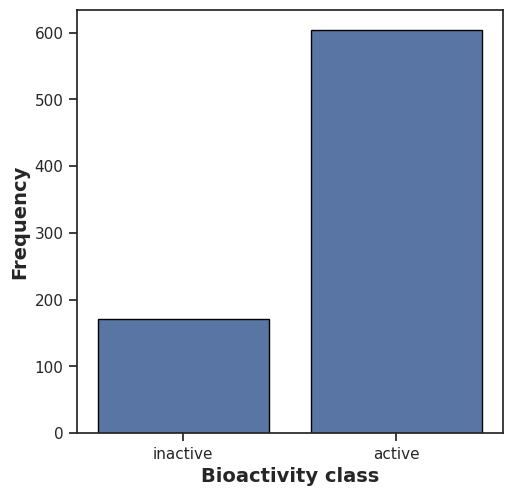

In [11]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_combined, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot MW vs LogP

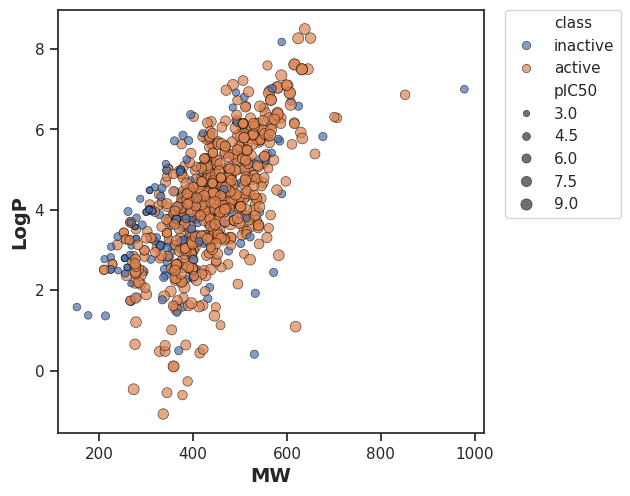

In [12]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df2, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### pIC50 Value Boxplots

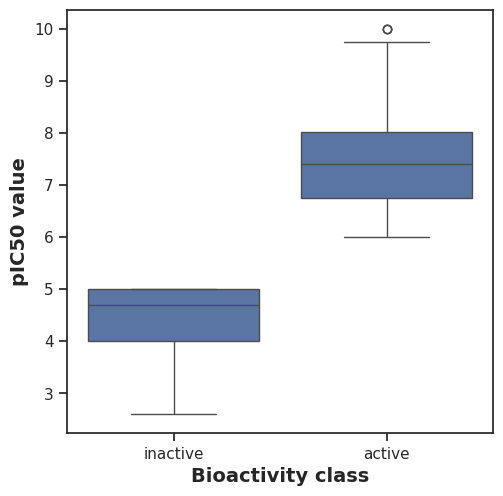

In [13]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

### **Statistical analysis | Mann-Whitney U Test**

In [14]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df2[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df2[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [15]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,103284.00,0.00,0.05,Different distribution (reject H0)


tolak h0 artinya ada perbedaan antara 2 data tersebut

### MW

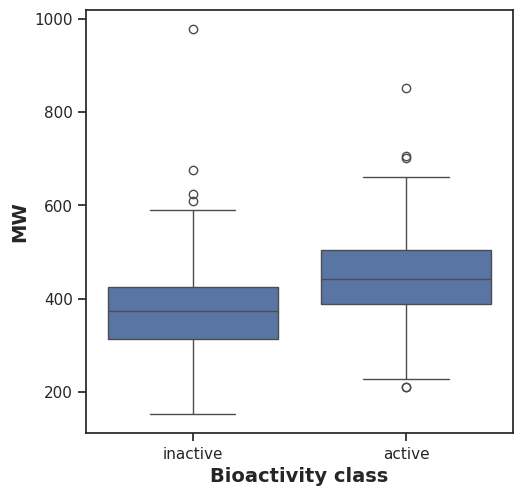

In [16]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [17]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,72954.50,0.00,0.05,Different distribution (reject H0)


### LogP

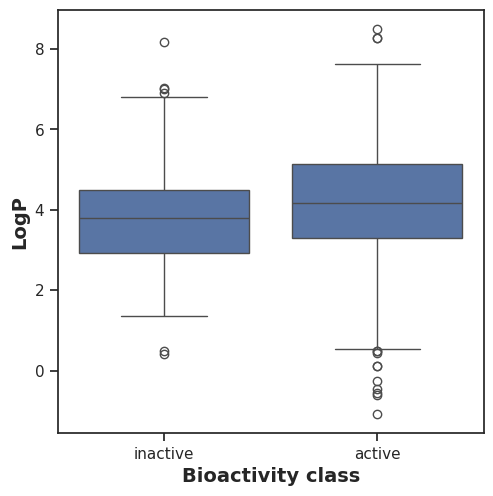

In [18]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [19]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,61570.50,0.00,0.05,Different distribution (reject H0)


### NumHDonors

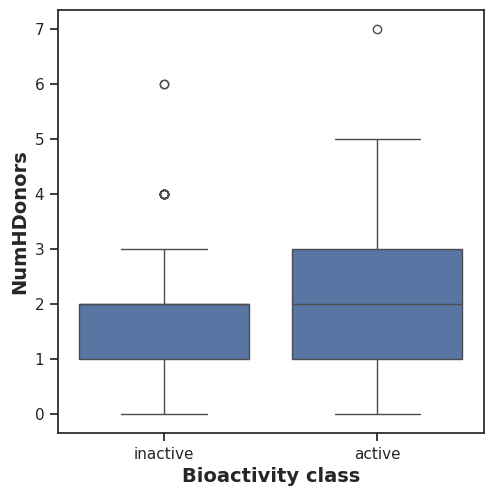

In [20]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [21]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,62013.50,0.00,0.05,Different distribution (reject H0)


### NumHAcceptors

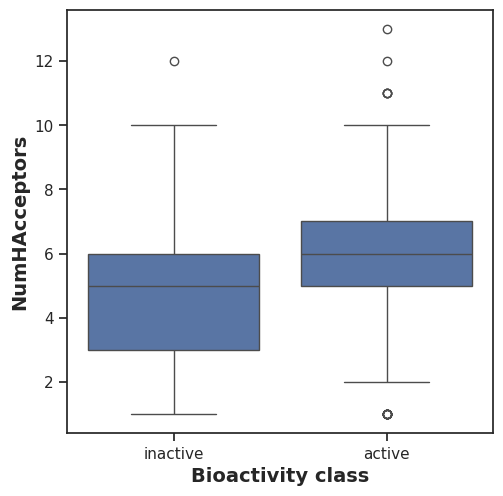

In [22]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [23]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,69258.50,0.00,0.05,Different distribution (reject H0)


# Preprocessing

## Laber Encoder

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_combined['class_num'] = le.fit_transform(df_combined['class'])
df_combined['class_num'].unique()
df_combined

,0,1,2,3,4,5,6,7,8,9,...,NumHAcceptors,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50,class_num
0,0,1,1,0,1,0,0,1,1,1,...,6.00,CHEMBL2332869,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(OC(F)...,430.35,4.69,3.00,6.00,4.75,1
1,0,1,1,0,1,0,0,1,1,1,...,5.00,CHEMBL2332868,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(F)c1,364.34,3.93,3.00,5.00,4.78,1
2,0,1,1,0,1,0,0,1,1,1,...,7.00,CHEMBL2332866,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1ccc(N2CCOC...,431.46,3.63,3.00,7.00,4.00,1
3,1,1,1,0,0,0,0,1,1,1,...,5.00,CHEMBL2332865,inactive,O=C(Nc1ccc(F)cc1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,364.34,3.93,3.00,5.00,4.05,1
4,0,1,1,0,0,0,0,1,1,1,...,5.00,CHEMBL2332864,inactive,O=C(NCC1CCCCC1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,366.43,3.85,3.00,5.00,4.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1,1,0,0,1,0,1,0,0,0,...,6.00,CHEMBL412102,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F...,475.86,5.31,4.00,6.00,7.31,0
771,1,1,0,0,0,0,1,0,0,0,...,6.00,CHEMBL429516,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(F)c(C(F)(F)F)...,459.41,4.80,4.00,6.00,6.46,0
772,1,1,0,0,1,0,0,0,0,0,...,6.00,CHEMBL409872,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3cccc(Cl)c3)cc1)CCN2,407.87,4.29,4.00,6.00,7.30,0
773,1,1,0,0,0,0,0,1,1,1,...,8.00,CHEMBL261592,active,Cc1cc2cc(Nc3ncnn4cc(-c5nnc(C)o5)c(C(C)C)c34)cn...,388.44,4.14,2.00,8.00,7.28,0


## isinya semua numerik

In [25]:
print(df_combined.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       'NumHAcceptors', 'molecule_chembl_id', 'class', 'canonical_smiles',
       'MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50', 'class_num'],
      dtype='object', length=178)


In [26]:
df_1 = df_combined.drop(columns=["molecule_chembl_id","canonical_smiles","class","pIC50"])
df_1

,0,1,2,3,4,5,6,7,8,9,...,163,MW,LogP,NumHDonors,NumHAcceptors,MW,LogP,NumHDonors,NumHAcceptors,class_num
0,0,1,1,0,1,0,0,1,1,1,...,0,430.35,4.69,3.00,6.00,430.35,4.69,3.00,6.00,1
1,0,1,1,0,1,0,0,1,1,1,...,0,364.34,3.93,3.00,5.00,364.34,3.93,3.00,5.00,1
2,0,1,1,0,1,0,0,1,1,1,...,0,431.46,3.63,3.00,7.00,431.46,3.63,3.00,7.00,1
3,1,1,1,0,0,0,0,1,1,1,...,0,364.34,3.93,3.00,5.00,364.34,3.93,3.00,5.00,1
4,0,1,1,0,0,0,0,1,1,1,...,0,366.43,3.85,3.00,5.00,366.43,3.85,3.00,5.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1,1,0,0,1,0,1,0,0,0,...,0,475.86,5.31,4.00,6.00,475.86,5.31,4.00,6.00,0
771,1,1,0,0,0,0,1,0,0,0,...,0,459.41,4.80,4.00,6.00,459.41,4.80,4.00,6.00,0
772,1,1,0,0,1,0,0,0,0,0,...,0,407.87,4.29,4.00,6.00,407.87,4.29,4.00,6.00,0
773,1,1,0,0,0,0,0,1,1,1,...,0,388.44,4.14,2.00,8.00,388.44,4.14,2.00,8.00,0


In [27]:
df_1 = df_1.astype(float)

## isinya hasil padel semua

In [28]:
df_2 = df_combined.drop(columns=["molecule_chembl_id","canonical_smiles","class","pIC50","class_num", 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors'])
df_2

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,163
0,0,1,1,0,1,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
1,0,1,1,0,1,0,0,1,1,1,...,0,0,0,0,1,0,1,0,0,0
2,0,1,1,0,1,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
3,1,1,1,0,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
4,0,1,1,0,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
771,1,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
772,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
773,1,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [29]:
X = df_2.astype(float)
X

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,163
0,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
2,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
771,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
772,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
773,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [30]:
y = df_combined['class_num']
y

,class_num
0,1
1,1
2,1
3,1
4,1
...,...
770,0
771,0
772,0
773,0


#Split data

## Lipinski & Padel


In [31]:
from sklearn.preprocessing import StandardScaler

X1 = df_1.drop(columns='class_num')
scaler = StandardScaler()
X1 = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)
X1
y1 = df_1['class_num']

In [32]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((620, 172), (155, 172), (620,), (155,))

In [33]:
import numpy as np

X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)
X_test1 = np.array(X_test1)
y_test1 = np.array(y_test1)


## hanya padel

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((620, 164), (155, 164), (620,), (155,))

## smote

In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled1, y_train_resampled1 = smote.fit_resample(X_train1, y_train1)

In [36]:
smote = pd.concat([X_train_resampled, y_train_resampled, df_combined['pIC50'], df_combined['MW'], df_combined['LogP']], axis=1)

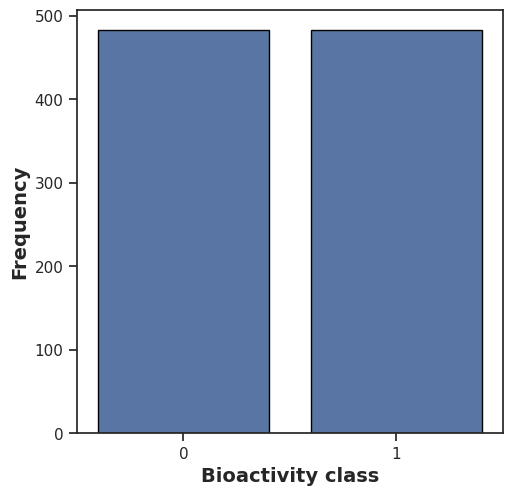

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class_num', data=smote, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

# Modelling xGBoost

## pake data padel saja

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from numpy.testing._private.utils import nulp_diff
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

y_pred_class = xgbc.predict(X_test)

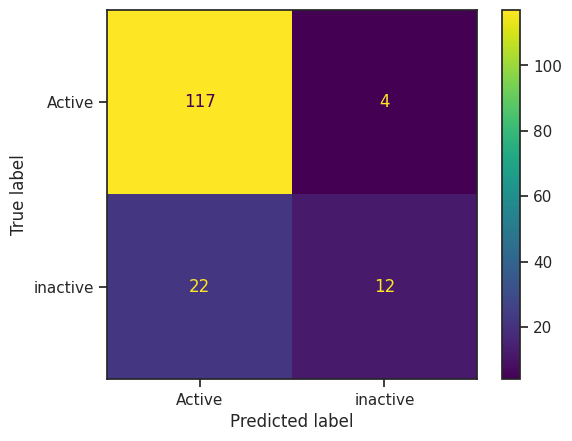

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       121
           1       0.75      0.35      0.48        34

    accuracy                           0.83       155
   macro avg       0.80      0.66      0.69       155
weighted avg       0.82      0.83      0.81       155



In [39]:
cf_matrix = confusion_matrix(y_test , y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,  display_labels=['Active', 'inactive'])
disp.plot(values_format='')
plt.show()

print(classification_report(y_test , y_pred_class))

In [40]:
r1 = xgbc.score(X_test, y_test)
r2 = xgbc.score(X_train, y_train)
r2, r1

(0.964516129032258, 0.832258064516129)

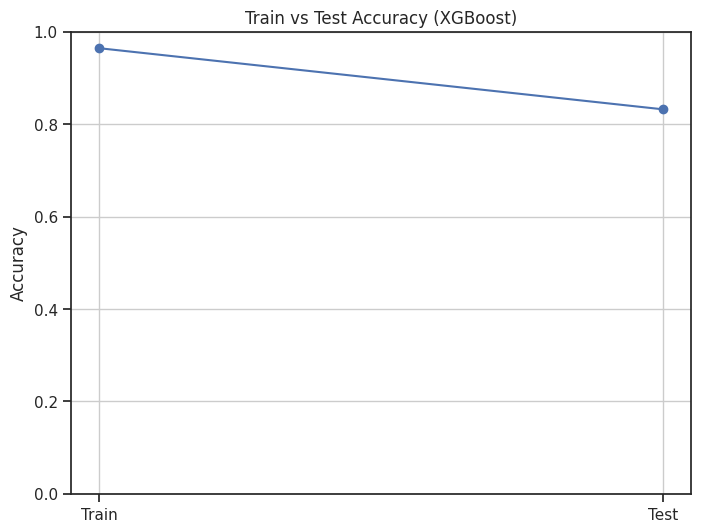

In [41]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(['Train', 'Test'], [r2, r1], marker='o')
plt.title('Train vs Test Accuracy (XGBoost)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for accuracy
plt.grid(True)
plt.show()

## model xGBoost dengan padel saja

In [42]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier(scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled))
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.94      0.90       121
           1       0.68      0.44      0.54        34

    accuracy                           0.83       155
   macro avg       0.77      0.69      0.72       155
weighted avg       0.82      0.83      0.82       155



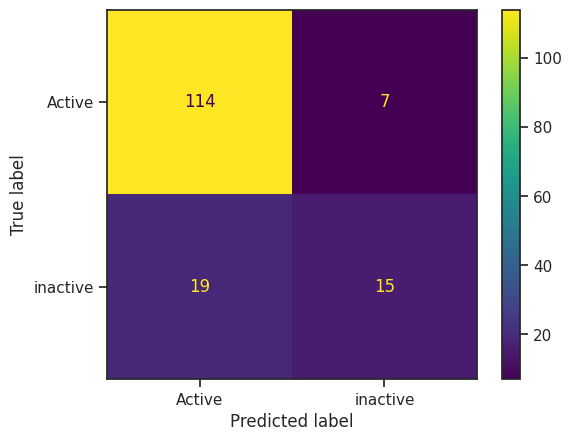

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       121
           1       0.68      0.44      0.54        34

    accuracy                           0.83       155
   macro avg       0.77      0.69      0.72       155
weighted avg       0.82      0.83      0.82       155



In [43]:
cf_matrix = confusion_matrix(y_test , y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,  display_labels=['Active', 'inactive'])
disp.plot(values_format='')
plt.show()

print(classification_report(y_test , y_pred))

In [44]:
r3 = model.score(X_train_resampled, y_train_resampled)
r4 = model.score(X_test, y_test)
r3, r4

(0.9751552795031055, 0.832258064516129)

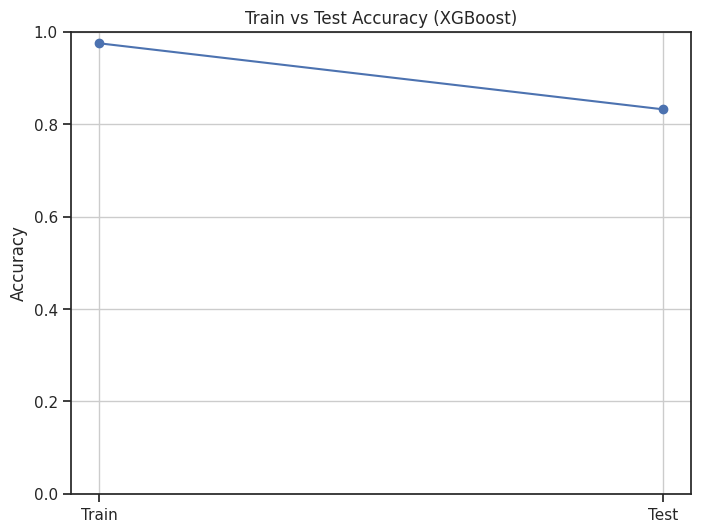

In [45]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(['Train', 'Test'], [r3, r4], marker='o')
plt.title('Train vs Test Accuracy (XGBoost)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for accuracy
plt.grid(True)
plt.show()

In [46]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

X = np.array(X)
y = np.array(y)

# Definisikan SMOTE dan model
smote = SMOTE(random_state=42)
model = XGBClassifier(scale_pos_weight=1)

# Buat pipeline untuk SMOTE dan model
pipeline = Pipeline([
    ('smote', smote),
    ('model', model)
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(pipeline, X, y, cv=cv, scoring=f1_scorer)

# Tampilkan hasil
print("F1-scores per fold with SMOTE:", scores)
print("Mean F1-score:", scores.mean())

F1-scores per fold with SMOTE: [0.83535484 0.80297012 0.84158143 0.84052066 0.79942768]
Mean F1-score: 0.8239709457241224


In [47]:
reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
train,test = reg.fit(X_train_resampled, X_test, y_train_resampled, y_test)
train1,test1 = reg.fit(X_train, X_test, y_train, y_test)#gapake smote

 97%|█████████▋| 31/32 [00:16<00:00,  2.12it/s]

[LightGBM] [Info] Number of positive: 483, number of negative: 483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


 97%|█████████▋| 31/32 [00:04<00:00,  9.03it/s]

[LightGBM] [Info] Number of positive: 137, number of negative: 483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 620, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220968 -> initscore=-1.260036
[LightGBM] [Info] Start training from score -1.260036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

100%|██████████| 32/32 [00:05<00:00,  6.15it/s]


In [48]:
train

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.81,0.75,0.75,0.81,0.19
NuSVC,0.82,0.74,0.74,0.82,0.55
SVC,0.81,0.71,0.71,0.81,0.32
LinearSVC,0.79,0.69,0.69,0.79,0.47
Perceptron,0.75,0.69,0.69,0.76,0.25
RandomForestClassifier,0.83,0.68,0.68,0.82,1.19
ExtraTreesClassifier,0.83,0.68,0.68,0.82,1.85
LabelPropagation,0.83,0.68,0.68,0.82,0.31
LabelSpreading,0.83,0.68,0.68,0.82,0.53


## cek lazy predict tidak pakai smote pada train

In [49]:
test

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.81,0.75,0.75,0.81,0.19
NuSVC,0.82,0.74,0.74,0.82,0.55
SVC,0.81,0.71,0.71,0.81,0.32
LinearSVC,0.79,0.69,0.69,0.79,0.47
Perceptron,0.75,0.69,0.69,0.76,0.25
RandomForestClassifier,0.83,0.68,0.68,0.82,1.19
ExtraTreesClassifier,0.83,0.68,0.68,0.82,1.85
LabelPropagation,0.83,0.68,0.68,0.82,0.31
LabelSpreading,0.83,0.68,0.68,0.82,0.53


In [50]:
train1

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.76,0.71,0.71,0.77,0.07
PassiveAggressiveClassifier,0.75,0.70,0.70,0.76,0.07
ExtraTreesClassifier,0.85,0.69,0.69,0.83,0.27
KNeighborsClassifier,0.84,0.69,0.69,0.82,0.04
ExtraTreeClassifier,0.81,0.68,0.68,0.80,0.03
SVC,0.85,0.67,0.67,0.82,0.14
RandomForestClassifier,0.84,0.66,0.66,0.81,0.45
LinearDiscriminantAnalysis,0.82,0.66,0.66,0.80,0.17
RidgeClassifierCV,0.83,0.66,0.66,0.81,0.17


In [51]:
test1

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.76,0.71,0.71,0.77,0.07
PassiveAggressiveClassifier,0.75,0.70,0.70,0.76,0.07
ExtraTreesClassifier,0.85,0.69,0.69,0.83,0.27
KNeighborsClassifier,0.84,0.69,0.69,0.82,0.04
ExtraTreeClassifier,0.81,0.68,0.68,0.80,0.03
SVC,0.85,0.67,0.67,0.82,0.14
RandomForestClassifier,0.84,0.66,0.66,0.81,0.45
LinearDiscriminantAnalysis,0.82,0.66,0.66,0.80,0.17
RidgeClassifierCV,0.83,0.66,0.66,0.81,0.17


[(0.0, 1.0)]

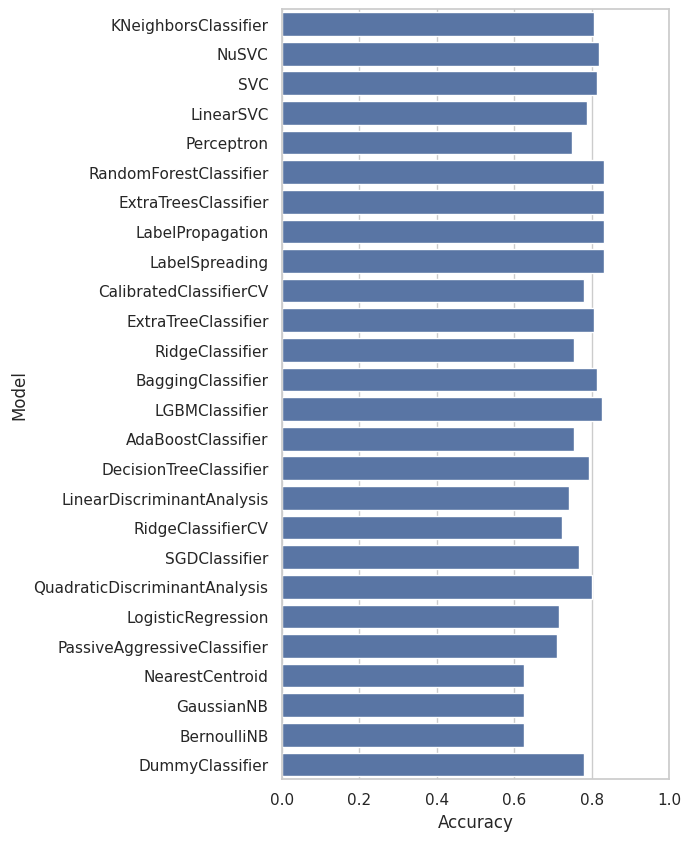

In [52]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="Accuracy", data=train)
ax.set(xlim=(0, 1))

[(0.0, 1.0)]

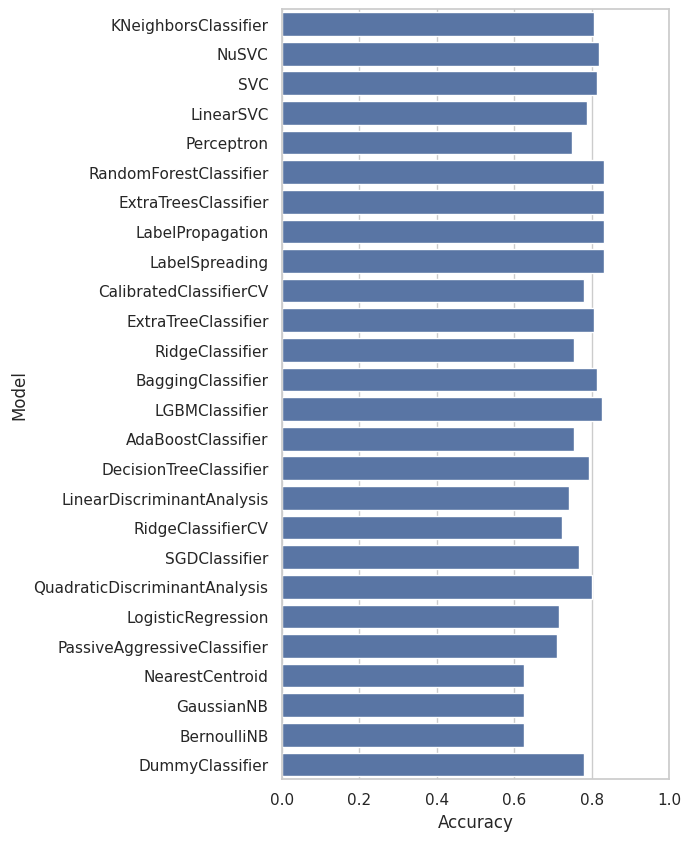

In [53]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=test.index, x="Accuracy", data=test)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

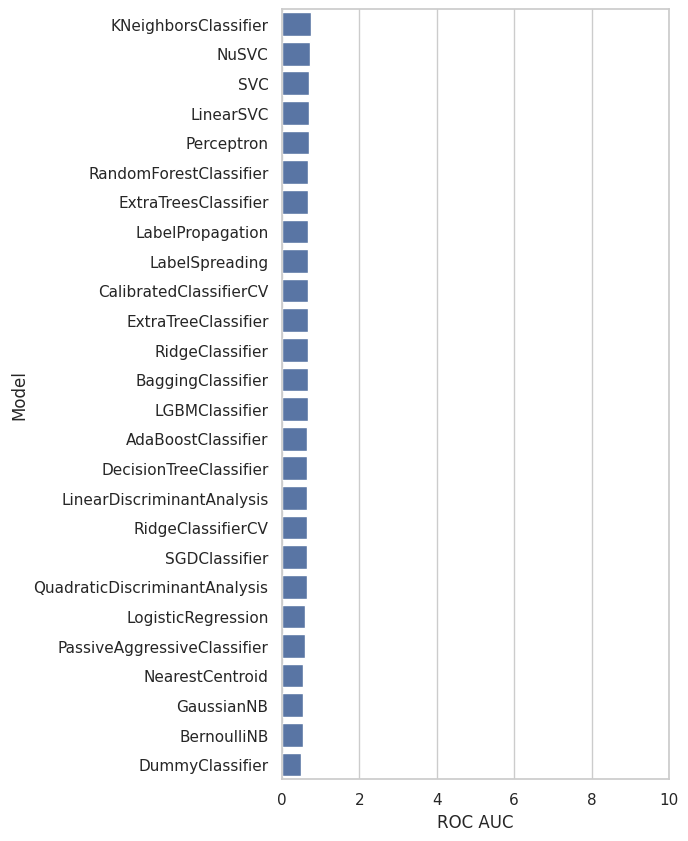

In [54]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="ROC AUC", data=train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

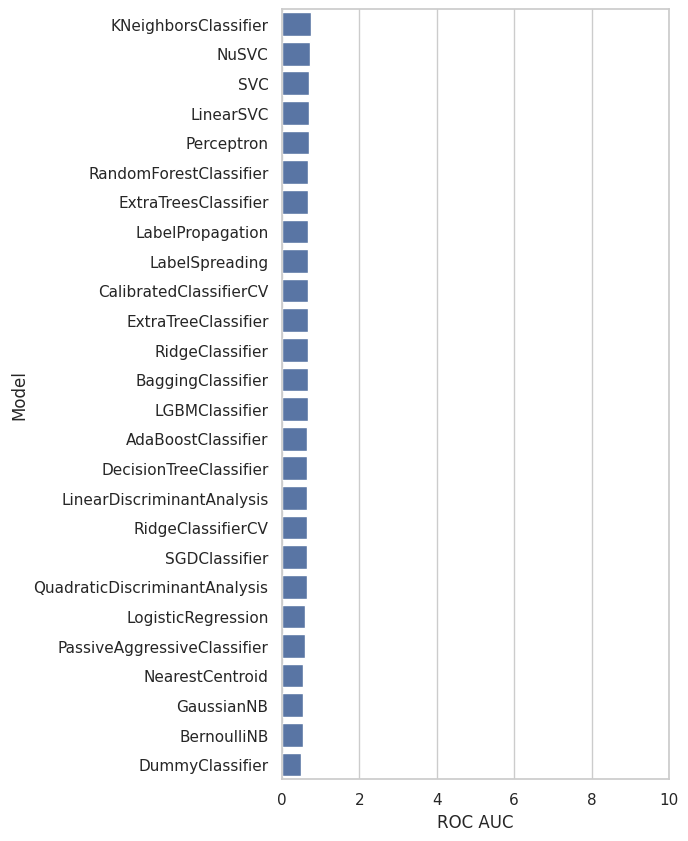

In [55]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=test.index, x="ROC AUC", data=test)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

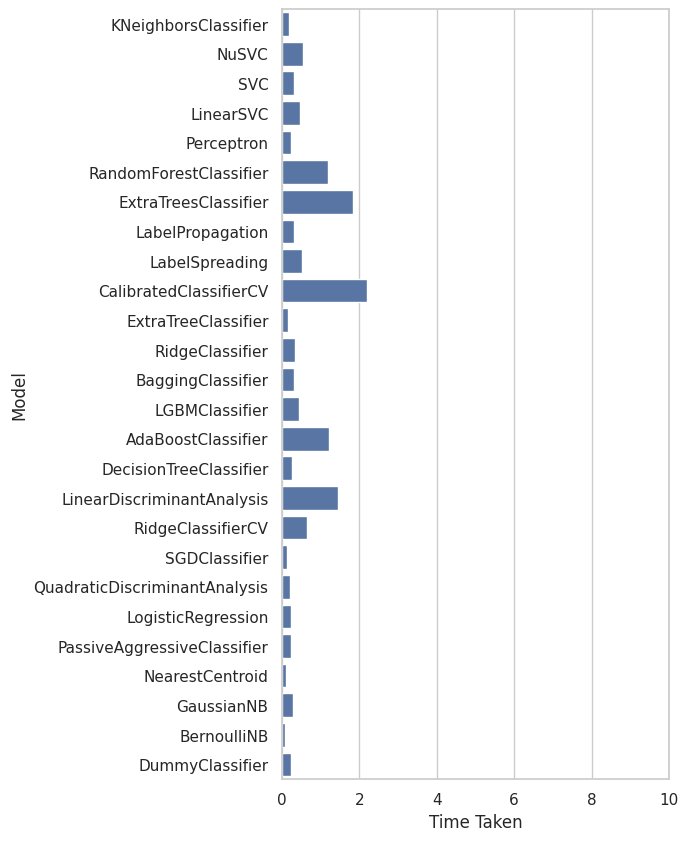

In [56]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="Time Taken", data=train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

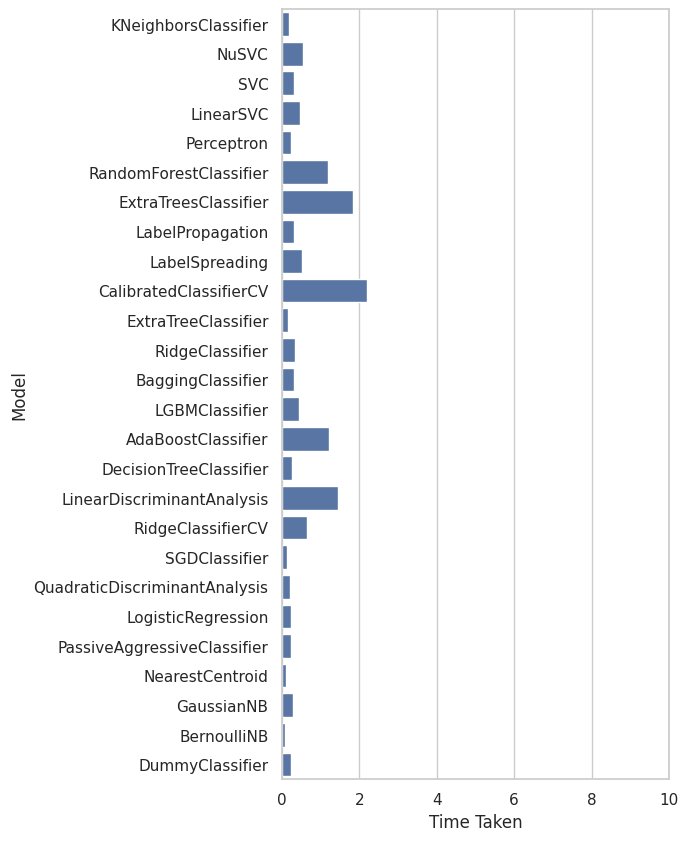

In [57]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=test.index, x="Time Taken", data=test)
ax.set(xlim=(0, 10))

# Modelling xGBoost2

## Menggunakan atribut Lipinski & Padel`

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from numpy.testing._private.utils import nulp_diff
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
xgbc = XGBClassifier()
xgbc.fit(X_train1, y_train1)

y_pred_class = xgbc.predict(X_test1)

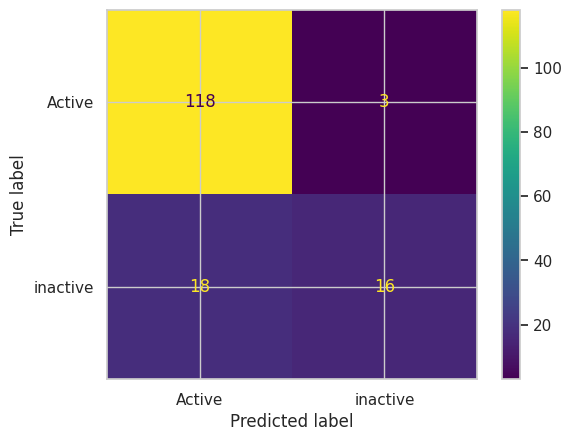

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       121
         1.0       0.84      0.47      0.60        34

    accuracy                           0.86       155
   macro avg       0.85      0.72      0.76       155
weighted avg       0.86      0.86      0.85       155



In [80]:
cf_matrix = confusion_matrix(y_test1 , y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,  display_labels=['Active', 'inactive'])
disp.plot(values_format="")
plt.show()

print(classification_report(y_test1 , y_pred_class))

In [60]:
r5 = xgbc.score(X_test1, y_test1)
r6 = xgbc.score(X_train1, y_train1)
r6, r5

(0.9967741935483871, 0.864516129032258)

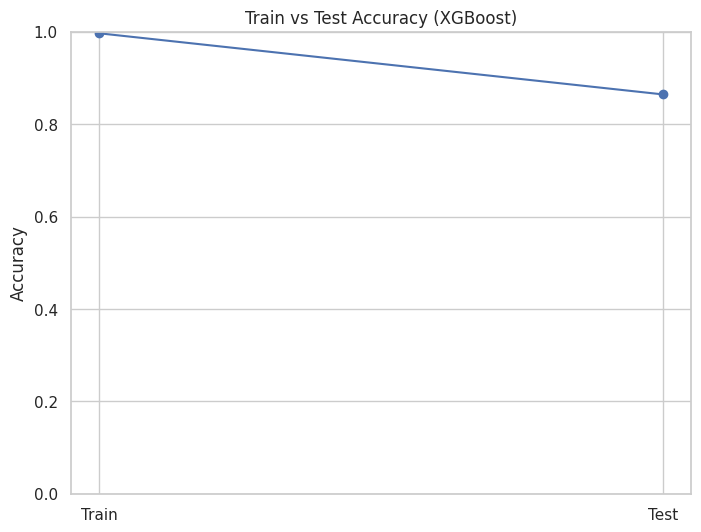

In [61]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(['Train', 'Test'], [r6, r5], marker='o')
plt.title('Train vs Test Accuracy (XGBoost)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for accuracy
plt.grid(True)
plt.show()

## model xGBoost-smote dengan atribut lainnya

In [62]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier(scale_pos_weight=len(y_train_resampled1) / sum(y_train_resampled1))
model.fit(X_train_resampled1, y_train_resampled1)

y_pred = model.predict(X_test1)
print(classification_report(y_test1, y_pred))


              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       121
         1.0       0.86      0.53      0.65        34

    accuracy                           0.88       155
   macro avg       0.87      0.75      0.79       155
weighted avg       0.88      0.88      0.87       155



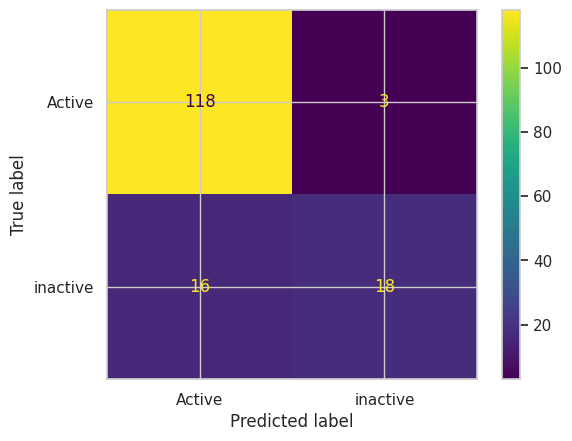

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       121
         1.0       0.86      0.53      0.65        34

    accuracy                           0.88       155
   macro avg       0.87      0.75      0.79       155
weighted avg       0.88      0.88      0.87       155



In [81]:
cf_matrix = confusion_matrix(y_test1 , y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,  display_labels=['Active', 'inactive'])
disp.plot(values_format='')
plt.show()

print(classification_report(y_test1 , y_pred))

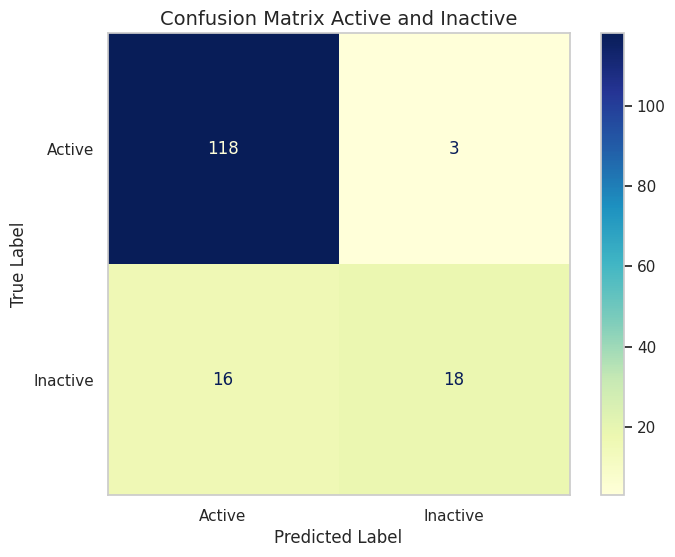

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Data for example (replace with your own data)
confusion_matrix = np.array([[118, 3], [16, 18]])
display_labels = ["Active", "Inactive"]

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

# Plot with modifications
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="YlGnBu", colorbar=True)  # Use a brighter colormap

# Customize font size and grid visibility
plt.title("Confusion Matrix Active and Inactive", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.grid(False)  # Disable the grid for better clarity
plt.show()


In [64]:
r7 = model.score(X_train_resampled1, y_train_resampled1)
r8 = model.score(X_test1, y_test1)
r7, r8

(0.9968944099378882, 0.8774193548387097)

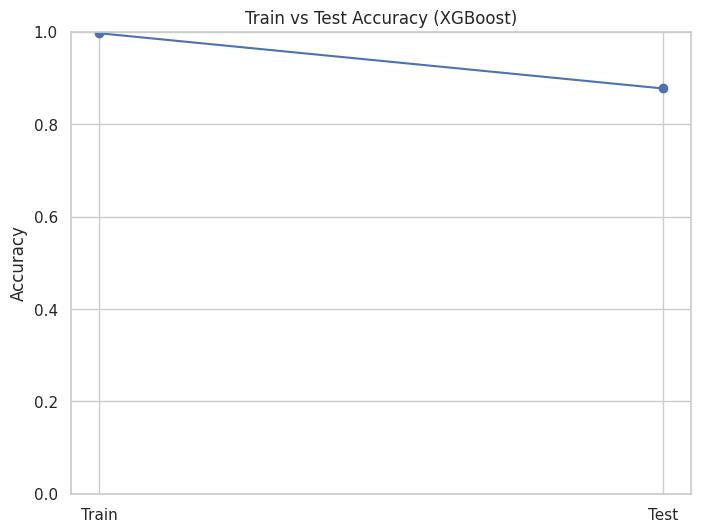

In [65]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(['Train', 'Test'], [r7, r8], marker='o')
plt.title('Train vs Test Accuracy (XGBoost)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for accuracy
plt.grid(True)
plt.show()

In [66]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

X1 = np.array(X1)
y1 = np.array(y1)

# Definisikan SMOTE dan model
smote = SMOTE(random_state=42)
model = XGBClassifier(scale_pos_weight=1)

# Buat pipeline untuk SMOTE dan model
pipeline = Pipeline([
    ('smote', smote),
    ('model', model)
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(pipeline, X1, y1, cv=cv, scoring=f1_scorer)

# Tampilkan hasil
print("F1-scores per fold with SMOTE:", scores)
print("Mean F1-score:", scores.mean())

F1-scores per fold with SMOTE: [0.84676095 0.83597508 0.84158143 0.86019086 0.85661161]
Mean F1-score: 0.8482239876958776


In [67]:
reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
train2,test2 = reg.fit(X_train_resampled1, X_test1, y_train_resampled1, y_test1)
train3,test3 = reg.fit(X_train1, X_test1, y_train1, y_test1)#gapake smote

 97%|█████████▋| 31/32 [00:04<00:00,  7.91it/s]

[LightGBM] [Info] Number of positive: 483, number of negative: 483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


 97%|█████████▋| 31/32 [00:05<00:00,  3.45it/s]

[LightGBM] [Info] Number of positive: 137, number of negative: 483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 620, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220968 -> initscore=-1.260036
[LightGBM] [Info] Start training from score -1.260036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

100%|██████████| 32/32 [00:06<00:00,  5.23it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [68]:
train2

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.82,0.77,0.77,0.82,0.04
NuSVC,0.83,0.73,0.73,0.82,0.14
BaggingClassifier,0.87,0.73,0.73,0.86,0.23
DecisionTreeClassifier,0.81,0.72,0.72,0.81,0.07
SVC,0.82,0.72,0.72,0.82,0.13
RandomForestClassifier,0.85,0.69,0.69,0.83,0.43
ExtraTreeClassifier,0.81,0.69,0.69,0.80,0.03
LGBMClassifier,0.84,0.67,0.67,0.82,0.33
ExtraTreesClassifier,0.84,0.67,0.67,0.82,0.31


In [69]:
test2

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.82,0.77,0.77,0.82,0.04
NuSVC,0.83,0.73,0.73,0.82,0.14
BaggingClassifier,0.87,0.73,0.73,0.86,0.23
DecisionTreeClassifier,0.81,0.72,0.72,0.81,0.07
SVC,0.82,0.72,0.72,0.82,0.13
RandomForestClassifier,0.85,0.69,0.69,0.83,0.43
ExtraTreeClassifier,0.81,0.69,0.69,0.80,0.03
LGBMClassifier,0.84,0.67,0.67,0.82,0.33
ExtraTreesClassifier,0.84,0.67,0.67,0.82,0.31


## cek lazy predict tidak pakai smote pada train dan test

In [70]:
train3

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.76,0.70,0.70,0.77,0.05
ExtraTreesClassifier,0.86,0.70,0.70,0.84,0.40
KNeighborsClassifier,0.84,0.69,0.69,0.82,0.05
LGBMClassifier,0.85,0.68,0.68,0.83,0.36
BaggingClassifier,0.85,0.68,0.68,0.82,0.14
SVC,0.85,0.67,0.67,0.82,0.14
RandomForestClassifier,0.85,0.67,0.67,0.82,0.48
DecisionTreeClassifier,0.77,0.66,0.66,0.77,0.09
LinearSVC,0.81,0.64,0.64,0.79,0.20


In [71]:
test3

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.76,0.70,0.70,0.77,0.05
ExtraTreesClassifier,0.86,0.70,0.70,0.84,0.40
KNeighborsClassifier,0.84,0.69,0.69,0.82,0.05
LGBMClassifier,0.85,0.68,0.68,0.83,0.36
BaggingClassifier,0.85,0.68,0.68,0.82,0.14
SVC,0.85,0.67,0.67,0.82,0.14
RandomForestClassifier,0.85,0.67,0.67,0.82,0.48
DecisionTreeClassifier,0.77,0.66,0.66,0.77,0.09
LinearSVC,0.81,0.64,0.64,0.79,0.20


[(0.0, 1.0)]

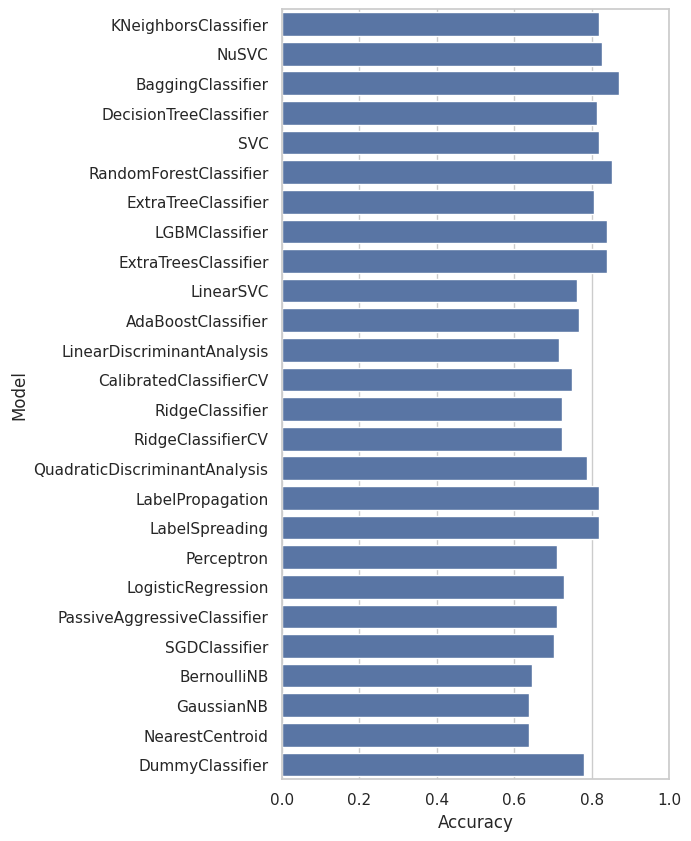

In [72]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train2.index, x="Accuracy", data=train2)
ax.set(xlim=(0, 1))

[(0.0, 1.0)]

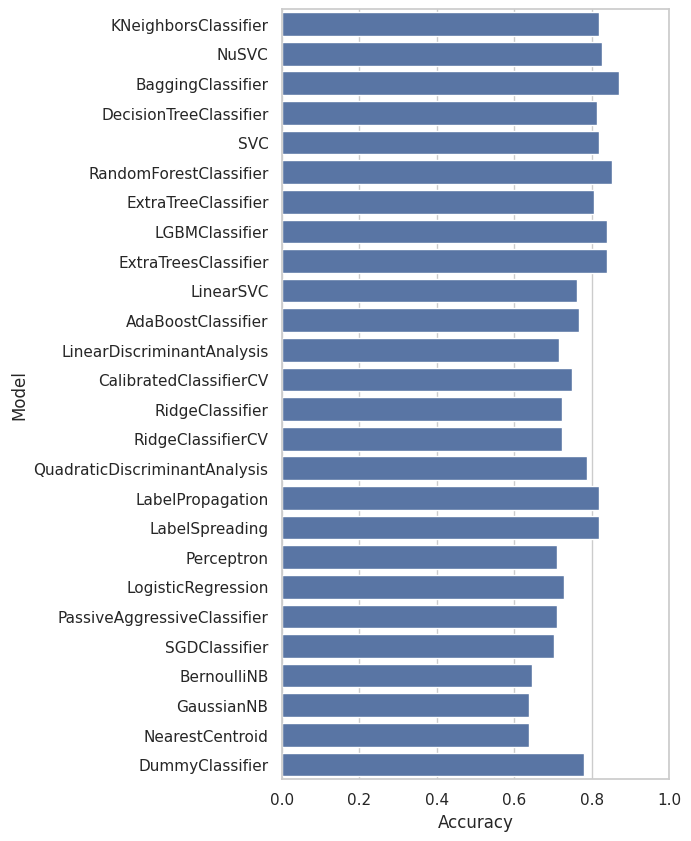

In [73]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=test2.index, x="Accuracy", data=test2)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

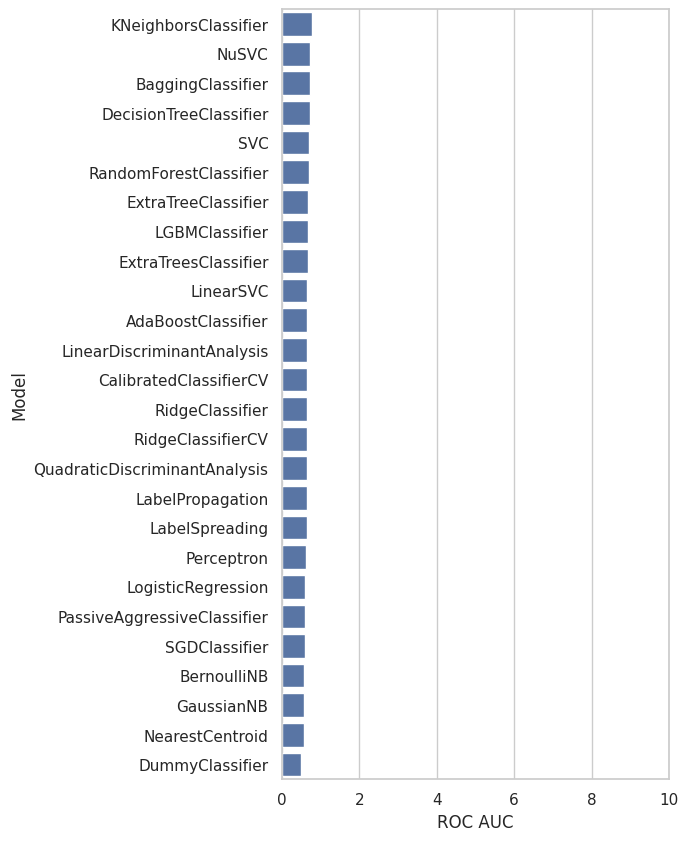

In [74]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train2.index, x="ROC AUC", data=train2)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

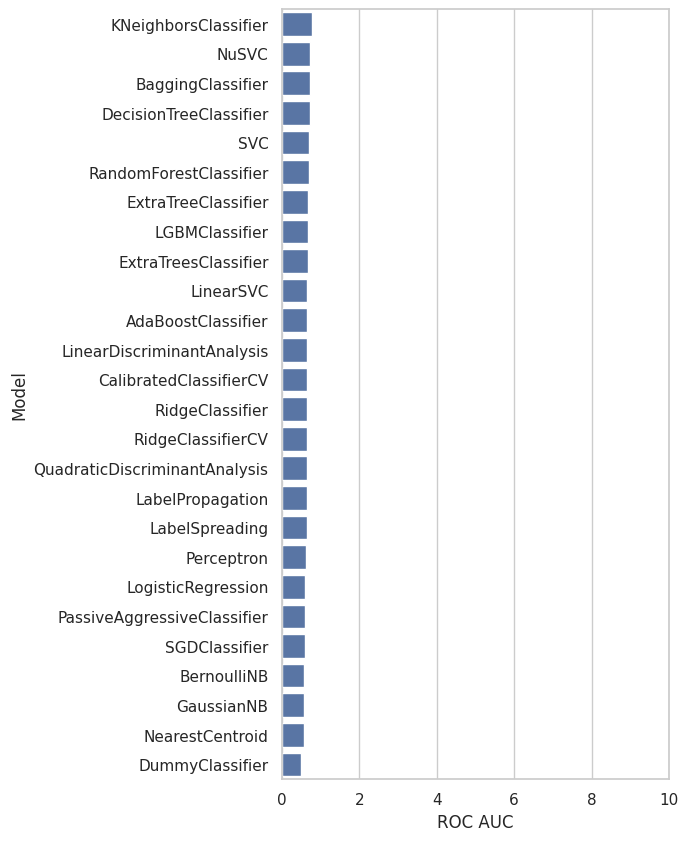

In [75]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=test2.index, x="ROC AUC", data=test2)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

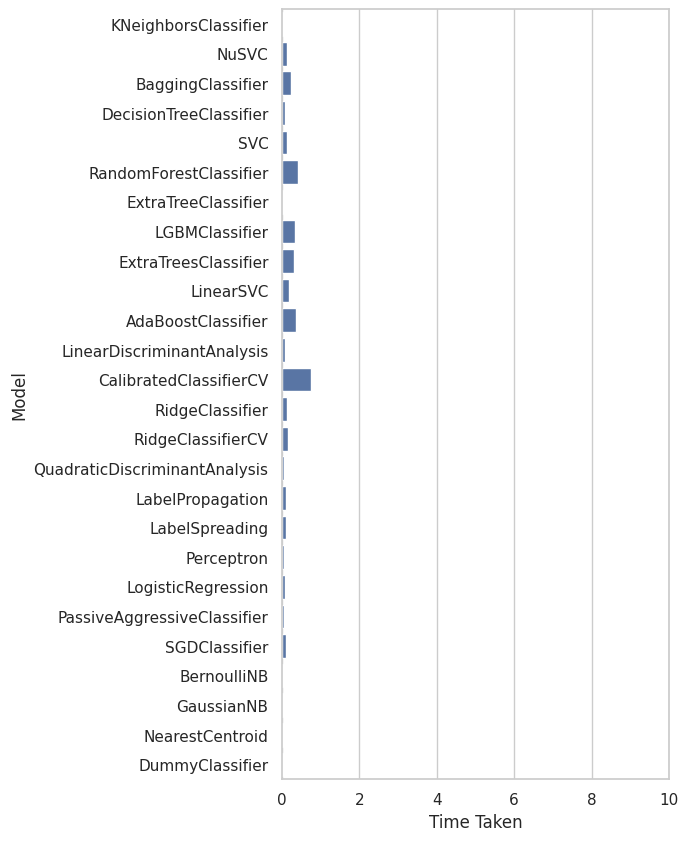

In [76]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train2.index, x="Time Taken", data=train2)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

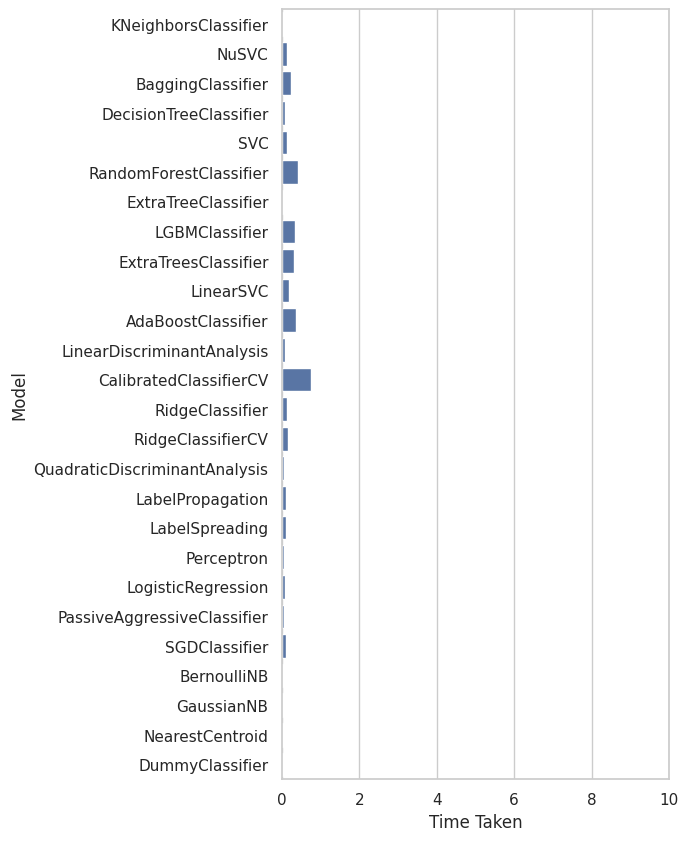

In [77]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=test2.index, x="Time Taken", data=test2)
ax.set(xlim=(0, 10))